In [1]:
from konlpy.utils import pprint
import io

def read_data(filename):
    with io.open(filename, 'r', encoding = "utf-8" ) as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

In [26]:
from konlpy.tag import Twitter

pos_tagger = Twitter()

def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

def filterbyvalue(seq, value):
    for el in seq:
        if el.attribute == value: yield el

train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

train_docs_pos = [ x for x in train_docs if x[1] == '1' ]
train_docs_neg = [ x for x in train_docs if x[1] == '0' ]

In [4]:
# 잘 들어갔는지 확인
print len( train_docs_pos )
print len( train_docs_neg )
pprint( train_docs_pos[0] )
pprint( train_docs_neg[0] )
pprint(train_docs[0])
pprint( train_data[0] )

74827
75173
([흠/Noun,
  .../Punctuation,
  포스터/Noun,
  보고/Noun,
  초딩/Noun,
  영화/Noun,
  줄/Noun,
  ..../Punctuation,
  오버/Noun,
  연기/Noun,
  조차/Josa,
  가볍다/Adjective,
  않다/Verb],
 1)
([아/Exclamation,
  더빙/Noun,
  ../Punctuation,
  진짜/Noun,
  짜증/Noun,
  나다/Verb,
  목소리/Noun],
 0)
([아/Exclamation,
  더빙/Noun,
  ../Punctuation,
  진짜/Noun,
  짜증/Noun,
  나다/Verb,
  목소리/Noun],
 0)
[9976970,
 아 더빙.. 진짜 짜증나네요 목소리,
 0]


In [5]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


In [39]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [7]:
# 여기서는 최빈도 단어 2000개를 피쳐로 사용
# WARNING: 쉬운 이해를 위한 코드이며 time/memory efficient하지 않습니다
selected_words = [f[0] for f in text.vocab().most_common(2000)]
#selected_words = selected_words[ 50 : ]

In [8]:
def term_exists(doc):
    return {u'exists({})'.format(word): (word in set(doc)) for word in selected_words}

# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_docs_df = train_docs[:10000]

train_xy = [(term_exists(d), c) for d, c in train_docs_df]
test_xy = [(term_exists(d), c) for d, c in train_docs_df]

In [40]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

classifier = nltk.NaiveBayesClassifier.train( train_xy )
print( nltk.classify.accuracy( classifier, test_xy ) )

0.83514


In [9]:
classifier.show_most_informative_features()

Most Informative Features
         exists(수작/Noun) = True                1 : 0      =     38.0 : 1.0
         exists(최악/Noun) = True                0 : 1      =     30.1 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     24.5 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     22.1 : 1.0
         exists(낭비/Noun) = True                0 : 1      =     19.5 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     19.4 : 1.0
         exists(여운/Noun) = True                1 : 0      =     18.9 : 1.0
        exists(발연기/Noun) = True                0 : 1      =     16.9 : 1.0
          exists(굿/Noun) = True                1 : 0      =     16.9 : 1.0
        exists(최고다/Noun) = True                1 : 0      =     15.9 : 1.0


Gulim


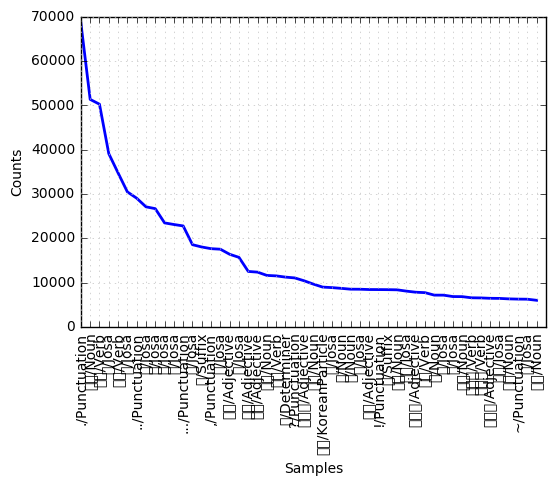

In [41]:
from __future__ import unicode_literals
from matplotlib import font_manager, rc
font_fname = "c:\\windows\\fonts\\gulim.ttc"
font_name = font_manager.FontProperties( fname = font_fname ).get_name()
print font_name
rc( "font", family = font_name )
rc('text', usetex='false') 
text.plot(50)

In [37]:
test_sent = u"세력들 장중조정 잘하고 있네요 세력들에게 물량 뺏기지 마시고 잘들 끝가지 홀딩해서 다같이 대박납시다."
test_sent = u"보인다. 쭉쭉가보자"
t = tokenize( test_sent )
pprint( t )
t = term_exists( t )
tt = classifier.classify( t )
tt

[보이다/Verb,
 ./Punctuation,
 쭉쭉/Noun,
 가보다/Verb]


u'1'

In [43]:
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
classifier1 = SklearnClassifier( LinearSVC() )
cfr = classifier1.train( train_xy )

In [44]:
print( nltk.classify.accuracy( cfr, test_xy ) )

0.83612


In [24]:
cfr.classify( t )

u'1'

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
pipeline = Pipeline( [ ( 'tfidf', TfidfTransformer() ), \
                     #( 'chi2', SelectKBest( chi2, k = 2000 ) ), \
                     ( 'nb', MultinomialNB() ) ] )
pipe_classifer = SklearnClassifier( pipeline )
pcfr = pipe_classifer.train( train_xy )

In [46]:
print( nltk.classify.accuracy( pcfr, test_xy ) )

0.83624


In [33]:
pcfr.classify( t )

u'1'

In [32]:
import collections, itertools
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist

word_fd = FreqDist()
label_word_fd = ConditionalFreqDist()

for word in train_docs_pos:
    for w in word[0]:
        word_fd[ w ] += 1
        label_word_fd[ 'pos' ][ w ] += 1
    
for word in train_docs_neg:
    for w in word[0]:
        word_fd[ w ] += 1
        label_word_fd[ 'neg' ][ w ] += 1
    
pos_word_count = label_word_fd[ 'pos' ].N()
neg_word_count = label_word_fd[ 'neg' ].N()
total_word_count = pos_word_count + neg_word_count

print pos_word_count, neg_word_count, total_word_count

word_scores = {}

for word, freq in word_fd.items():
    pos_score = BigramAssocMeasures.chi_sq( label_word_fd['pos'][word], \
                                           ( freq, pos_word_count ), total_word_count )
    neg_score = BigramAssocMeasures.chi_sq( label_word_fd['neg'][word], \
                                          ( freq, neg_word_count ), total_word_count )
    word_scores[ word ] = pos_score + neg_score
    
best = sorted( word_scores.iteritems(), key = lambda( w, s ): s, reverse = True )[ : 30000 ]
bestwords = set( [ w for w, s in best ] )

def best_word_feats( words ):
    return dict( [ ( word, True ) for word in words if word in bestwords ] )

def best_bigram_word_feats( words, score_fn = BigramAssocMeasures.chi_sq, n = 2000 ):
    bigram_finder = BigramCollocationFinder.from_words( words )
    bigrams = bigram_finder.nbest( score_fn, n )
    d = dict( [ ( bigram, True ) for bigram in bigrams ] )
    d.update( best_word_feats( words ) )
    return d

1064264 1130272 2194536


In [36]:
train_docs1 = train_docs[:100000]

train_xy = [(best_word_feats(d), c) for d, c in train_docs1]
test_xy = [(best_word_feats(d), c) for d, c in test_docs]

classifier = nltk.NaiveBayesClassifier.train( train_xy )
print u"Accuracy: {}".format( nltk.classify.accuracy( classifier, test_xy )  )  
classifier.show_most_informative_features()

Accuracy: 0.83514
Most Informative Features
                 최악/Noun = True                0 : 1      =     68.1 : 1.0
               ♥/Foreign = True                1 : 0      =     64.2 : 1.0
                 낚였/Noun = True                0 : 1      =     51.4 : 1.0
                 이도/Noun = True                0 : 1      =     50.1 : 1.0
                 반개/Noun = True                0 : 1      =     41.2 : 1.0
                 빵점/Noun = True                0 : 1      =     40.2 : 1.0
              Good/Alpha = True                1 : 0      =     35.8 : 1.0
                 낭비/Noun = True                0 : 1      =     35.8 : 1.0
                 노잼/Noun = True                0 : 1      =     35.2 : 1.0
               울컥/Adverb = True                1 : 0      =     34.5 : 1.0


In [47]:
pcfr = pipe_classifer.train( train_xy )
print u"Accuracy: {}".format( nltk.classify.accuracy( pcfr, test_xy )  )  

Accuracy: 0.83624


In [114]:
test_sent = u"영화  재미있네"
t = tokenize( test_sent )
pprint( t )
t = best_word_feats( t )
tt = classifier.classify( t )
tt

[영화/Noun, 재미있다/Adjective]


u'1'